# Braille Classifier

In [1]:
import os
import numpy as np
import pandas as pd
from shutil import copyfile

In [2]:
os.mkdir('./images/')
alpha = 'a'
for i in range(0, 26): 
    os.mkdir('./images/' + alpha)
    alpha = chr(ord(alpha) + 1)

rootdir = '/kaggle/input/braille-character-dataset/Braille Dataset/Braille Dataset/'
for file in os.listdir(rootdir):
    letter = file[0]
    copyfile(rootdir+file, './images/' + letter + '/' + file)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('./images/',
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory('./images/',
                                            target_size=(28,28),
                                            subset='validation')

Using TensorFlow backend.


Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [4]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=666,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

Epoch 1/666
39/39 [==============================] - 3s 64ms/step - loss: 3.2825 - accuracy: 0.0361 - val_loss: 3.2648 - val_accuracy: 0.0481
Epoch 2/666
39/39 [==============================] - 2s 55ms/step - loss: 3.1412 - accuracy: 0.0865 - val_loss: 3.1822 - val_accuracy: 0.1699
Epoch 3/666
39/39 [==============================] - 2s 54ms/step - loss: 2.6646 - accuracy: 0.2332 - val_loss: 2.5187 - val_accuracy: 0.3237
Epoch 4/666
39/39 [==============================] - 2s 55ms/step - loss: 2.0620 - accuracy: 0.3854 - val_loss: 1.6555 - val_accuracy: 0.4263
Epoch 5/666
39/39 [==============================] - 2s 54ms/step - loss: 1.6604 - accuracy: 0.4984 - val_loss: 1.4442 - val_accuracy: 0.5673
Epoch 6/666
39/39 [==============================] - 2s 52ms/step - loss: 1.3643 - accuracy: 0.5809 - val_loss: 1.3183 - val_accuracy: 0.6186
Epoch 7/666
39/39 [==============================] - 2s 50ms/step - loss: 1.1927 - accuracy: 0.6530 - val_loss: 0.8214 - val_accuracy: 0.6891
Epoch 

In [5]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 26, 26, 64)        283       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 11, 11, 128)       8896      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 4, 4, 256)         33536     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 256)               0   

In [6]:
model = load_model('BrailleNet.h5')
acc = model.evaluate_generator(val_generator)[1]
print('model accuracy: {}'.format(round(acc,4)))

model accuracy: 0.9135


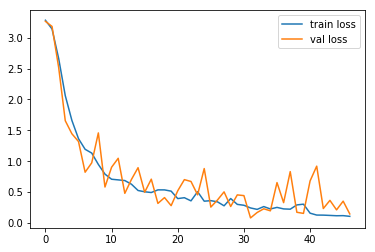

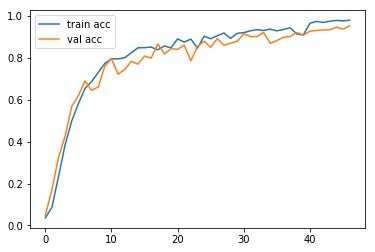

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [8]:
pred = model.predict(val_generator)
pred

array([[8.86672581e-07, 2.14265454e-14, 5.93166902e-08, ...,
        6.63643004e-06, 3.72805839e-15, 3.21890740e-03],
       [1.27287405e-02, 5.24733623e-05, 9.50311642e-06, ...,
        1.70570402e-08, 2.58954251e-12, 6.80051171e-09],
       [9.68776666e-19, 3.71396981e-18, 3.75970552e-22, ...,
        3.46146976e-07, 4.82941505e-06, 7.81337803e-07],
       ...,
       [2.95592400e-07, 3.07040386e-06, 7.03951120e-01, ...,
        1.60700165e-23, 9.79928366e-35, 1.56759467e-11],
       [2.51153142e-06, 1.18253361e-07, 1.06642403e-06, ...,
        1.37120511e-08, 4.13737412e-17, 1.03951823e-02],
       [1.14240020e-17, 4.22281601e-14, 1.02268054e-13, ...,
        5.37907797e-16, 1.54437183e-27, 1.74129652e-11]], dtype=float32)

In [9]:
from tensorflow.keras.preprocessing import image
img=image.load_img('dataset/Braille Dataset/Braille Dataset/a1.JPG0dim.jpg')

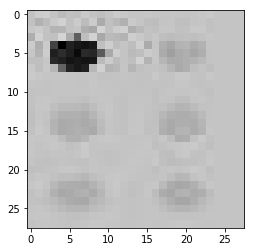

In [10]:
plt.imshow(img)

In [11]:
x=image.img_to_array(img)
x

array([[[194., 194., 194.],
        [204., 204., 204.],
        [206., 206., 206.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[193., 193., 193.],
        [177., 177., 177.],
        [188., 188., 188.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[199., 199., 199.],
        [203., 203., 203.],
        [195., 195., 195.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       ...,

       [[196., 196., 196.],
        [197., 197., 197.],
        [195., 195., 195.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[197., 197., 197.],
        [198., 198., 198.],
        [198., 198., 198.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[194., 194., 194.],
        [196., 196., 196.],
        [197., 1

In [12]:
x.shape

(28, 28, 3)

In [13]:
x=np.expand_dims(x,axis=0)
model.predict(x)

array([[9.8667961e-01, 1.7275304e-05, 3.7763387e-04, 1.9522693e-10,
        5.6219840e-05, 4.8356775e-05, 4.1345664e-12, 8.4848226e-09,
        3.6924132e-03, 1.8280493e-11, 8.9941155e-03, 3.1631004e-08,
        5.7942607e-06, 1.1871873e-09, 1.5060030e-07, 4.0847299e-06,
        6.2879693e-13, 5.3087418e-10, 9.2791233e-05, 4.2963894e-13,
        3.0574942e-05, 2.6732602e-10, 4.6131783e-17, 1.0071855e-06,
        6.4736797e-12, 3.4555416e-08]], dtype=float32)

In [14]:
a=np.argmax(model.predict(x), axis=1)
a

array([0])

In [15]:
from keras.layers import Dropout, BatchNormalization

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8, verbose=0)
early_stop = EarlyStopping(patience=15, verbose=1)

entry = L.Input(shape=(28, 28, 3))
x = L.SeparableConv2D(64, (3, 3), activation='relu')(entry)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D((2, 2))(x)

x = L.SeparableConv2D(128, (3, 3), activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D((2, 2))(x)

x = L.SeparableConv2D(256, (2, 2), activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.GlobalMaxPooling2D()(x)

x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dropout(0.5)(x)

x = L.Dense(64, kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dropout(0.5)(x)

x = L.Dense(26, activation='softmax')(x)

model = Model(entry, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=25,
                              callbacks=[model_ckpt, reduce_lr, early_stop],
                              verbose=1)

model.summary()

Epoch 1/666
39/39 [==============================] - 4s 104ms/step - loss: 4.3970 - accuracy: 0.0513 - val_loss: 3.2766 - val_accuracy: 0.0513
Epoch 2/666
39/39 [==============================] - 3s 71ms/step - loss: 3.3662 - accuracy: 0.0833 - val_loss: 3.2714 - val_accuracy: 0.0385
Epoch 3/666
39/39 [==============================] - 3s 73ms/step - loss: 3.2053 - accuracy: 0.1130 - val_loss: 3.2567 - val_accuracy: 0.0449
Epoch 4/666
39/39 [==============================] - 3s 78ms/step - loss: 3.0140 - accuracy: 0.1418 - val_loss: 3.2105 - val_accuracy: 0.0513
Epoch 5/666
39/39 [==============================] - 3s 75ms/step - loss: 2.8013 - accuracy: 0.2083 - val_loss: 3.0770 - val_accuracy: 0.1635
Epoch 6/666
39/39 [==============================] - 3s 76ms/step - loss: 2.6057 - accuracy: 0.2260 - val_loss: 3.1049 - val_accuracy: 0.2468
Epoch 7/666
39/39 [==============================] - 3s 78ms/step - loss: 2.3925 - accuracy: 0.2804 - val_loss: 2.9515 - val_accuracy: 0.2724
Epoch

In [16]:
# Load the trained model
model = load_model('BrailleNet.h5')

# Evaluate the model on the validation generator
eval_results = model.evaluate_generator(val_generator)

# Extract the accuracy from the evaluation results
accuracy = eval_results[1]

# Print the accuracy
print('Validation Accuracy: {:.2%}'.format(accuracy))

Validation Accuracy: 93.91%


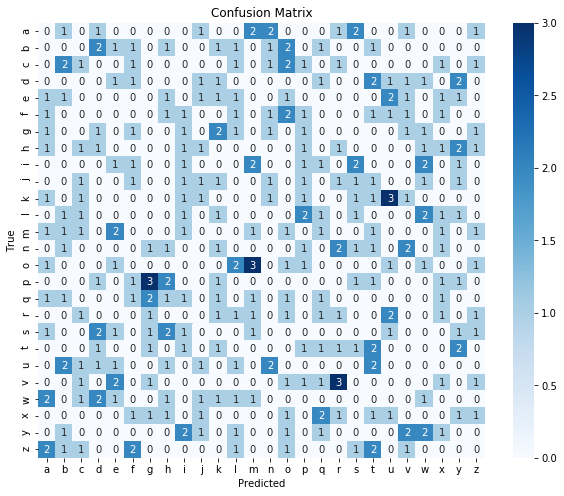

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

# Load the trained model
model = load_model('BrailleNet.h5')

# Predict labels for the validation set
y_pred = model.predict_generator(val_generator).argmax(axis=1)

# True labels for the validation set
y_true = val_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

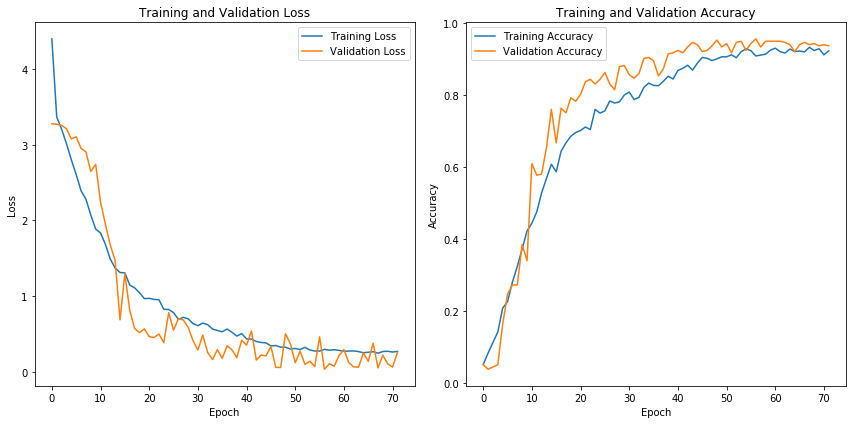

In [18]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history obtained during model training

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()